# Predicting customer churn
A telecom operator offering telephony and Internet services wants to know in advance which of the existing customers could potentially refuse services. With this information, it is possible, for example, if the user plans to leave, offer him special conditions in an attempt to retain the client.

The goal of the project is to develop a model for predicting customer churn. For this, personal data about some customers, as well as information about their tariffs and contracts are provided.

## Work plan

1. **Initial data processing.** Getting to know the data - 4 separate datasets that can be combined into one by a common key - client id.
2. **Data analysis.** We are faced with the task of classifying whether the client will refuse services or not. The target characteristic is based on the values in the service end date column. Here we explore patterns and anomalies.
3. **Selection of models.** Next, data preparation, dividing the dataset into training and test sets in compliance with the balance of classes, and carrying out the necessary transformations (scaling and coding). We select the most suitable models for the task and their hyperparameters on the cross-validation of the training set.
4. **Testing the model.** We check the quality metric of the final model on the test set.
5. **Conclusoion report.**

## Initial data processing

In [1]:
# used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from phik.report import plot_correlation_matrix

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
import time

In [2]:
# constants
RANDOM_STATE = 270223
N_JOBS = -1

In [3]:
# loading up dataset
try:
    path = "/Users/asyl/Desktop/DS/sources/final/"
    contract = pd.read_csv(path + "contract.csv")
    internet = pd.read_csv(path + "internet.csv")
    personal = pd.read_csv(path + "personal.csv")
    phone = pd.read_csv(path + "phone.csv")
except:
    path = "" # path to servel folder
    contract = pd.read_csv(path + "contract.csv")
    internet = pd.read_csv(path + "internet.csv")
    personal = pd.read_csv(path + "personal.csv")
    phone = pd.read_csv(path + "phone.csv")

In [4]:
# function for data info
def show_info(df):
    display(df.info())
    display(df.describe(include="all"))
    display(df.head())
    print("-------------------------------")


# printing general info
df_list = [personal, contract, internet, phone]
for df in df_list:
    show_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


-------------------------------


The **personal** dataset contains information about the gender, age category, or rather, whether the client is an elderly person, the presence of dependents, and the marital status of the clients.

The **contract** dataset reflects data on the contract, start date and termination date (if available), type of payment (monthly, annual or 2-year), payment method (automatic debiting of funds from a bank account or card, issuance of an electronic invoice or mailing an invoice), the amount of the invoice for each month, and the total amount.

In the **internet** dataset - the type of connection to the Internet, the availability of additional services (streaming television, cloud storage, antivirus, website blocking and a dedicated technical support line).

In the **phone** dataset - a subscription to a fixed-line telephone service and the ability to maintain parallel lines during a call.

In [6]:
# uniting all datasets
df = pd.merge(personal, contract, how="outer", on="customerID")
df = pd.merge(df, internet, how="outer", on="customerID")
df = pd.merge(df, phone, how="outer", on="customerID")
df.rename(columns=lambda x: re.sub("(?<!^)(?=[A-Z])", "_", x).lower(), inplace=True)
df.rename(
    {"customer_i_d": "customer_id", "streaming_t_v": "streaming_tv"},
    axis=1,
    inplace=True,
)
# check
show_info(df)
print("Number of duplicates -", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   begin_date         7043 non-null   object 
 6   end_date           7043 non-null   object 
 7   type               7043 non-null   object 
 8   paperless_billing  7043 non-null   object 
 9   payment_method     7043 non-null   object 
 10  monthly_charges    7043 non-null   float64
 11  total_charges      7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

None

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
count,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,2,NaN,2,2,77,5,3,2,4,NaN,6531,2,2,2,2,2,2,2,2
top,7590-VHVEG,Male,NaN,No,No,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Fiber optic,No,No,No,No,No,No,No
freq,1,3555,NaN,3641,4933,366,5174,3875,4171,2365,NaN,11,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


-------------------------------
Number of duplicates - 0


So, we got a small dataset with 7043 objects, a lot of gaps and incorrect formats. Before proceeding with the analysis, all errors must be corrected.

There are 2 columns with dates, one reflects when the contract was started, the second - if and when it was finished. Based on these features, we can determine the target feature whether the user is a current customer or a former customer. In addition, instead of these signs of the beginning and end of the contract, it is better to create a new one - the period or term of the "life" of the client. To do this, we need to bring these columns to the appropriate format, also we consider the date of uploading the dataset - 2020-02-01 as the last date.

Among all features, only 2 are quantitative - this is the amount of payment for the month and the total amount of payments. Here, it is necessary to correct the formats as well.

All other features are categorical, and most of them are binary.

All gaps refer to categorical features that we can fill in so as not to reduce the already small dataset.

In [7]:
# changing the date formats
df["begin_date"] = pd.to_datetime(df["begin_date"], format="%Y-%m-%d")
df.loc[df["end_date"] == "No", "end_date"] = np.nan
df["end_date"] = pd.to_datetime(df["end_date"], format="%Y-%m-%d")

# creating new and deleting old features
df["target"] = 1
df.loc[df["end_date"].isnull(), "target"] = 0
df.loc[df["end_date"].isnull(), "end_date"] = "2020-02-01"
df["period"] = (df["end_date"] - df["begin_date"]).dt.days
df = df.drop(["begin_date", "end_date"], axis=1)
df.head()

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,1,61
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,1,61


In [8]:
# changing formats of quantitative features
df["total_charges"] = df["total_charges"].replace(" ", 0).astype(float)
df[df["total_charges"] == 0]

,customer_id,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
488,4472-LVYGI,Female,0,Yes,Yes,Two year,Yes,Bank transfer (automatic),52.55,0.0,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
753,3115-CZMZD,Male,0,No,Yes,Two year,No,Mailed check,20.25,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
936,5709-LVOEQ,Female,0,Yes,Yes,Two year,No,Mailed check,80.85,0.0,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,4367-NUYAO,Male,0,Yes,Yes,Two year,No,Mailed check,25.75,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1340,1371-DWPAZ,Female,0,Yes,Yes,Two year,No,Credit card (automatic),56.05,0.0,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
3331,7644-OMVMY,Male,0,Yes,Yes,Two year,No,Mailed check,19.85,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3826,3213-VVOLG,Male,0,Yes,Yes,Two year,No,Mailed check,25.35,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4380,2520-SGTTA,Female,0,Yes,Yes,Two year,No,Mailed check,20.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5218,2923-ARZLG,Male,0,Yes,Yes,One year,Yes,Mailed check,19.70,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6670,4075-WKNIU,Female,0,Yes,Yes,Two year,No,Mailed check,73.35,0.0,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Missing values in the total amount of payments coincided with objects whose contract began to operate from the date of data export (February 1, 2020), so these gaps were assigned the value `0`.

Next, we turn to categories. The client key is no longer needed. Missing values in separate columns refer to clients who did not use the corresponding services, so we set them to `No`.

In [9]:
# filling the missing values
df = df.set_index("customer_id")
df = df.fillna("No")
df["senior_citizen"] = df["senior_citizen"].astype("str")
show_info(df)

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             7043 non-null   object 
 1   senior_citizen     7043 non-null   object 
 2   partner            7043 non-null   object 
 3   dependents         7043 non-null   object 
 4   type               7043 non-null   object 
 5   paperless_billing  7043 non-null   object 
 6   payment_method     7043 non-null   object 
 7   monthly_charges    7043 non-null   float64
 8   total_charges      7043 non-null   float64
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines

None

,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
count,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043.000000
unique,2,2,2,2,3,2,4,NaN,NaN,3,2,2,2,2,2,2,2,NaN,NaN
top,Male,0,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,Fiber optic,No,No,No,No,No,No,No,NaN,NaN
freq,3555,5901,3641,4933,3875,4171,2365,NaN,NaN,3096,5024,4614,4621,4999,4336,4311,4072,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2279.734304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.265370,985.996166
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.794470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.441561,747.587844
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,398.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,273.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1394.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,883.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3786.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1676.000000


,gender,senior_citizen,partner,dependents,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,period
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,1,61
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,1,61


-------------------------------


During the initial data processing, we combined 4 datasets, filled in the missing values, corrected the formats, created new features and removed the redundant ones. The data is now ready for analysis.

## Data analysis


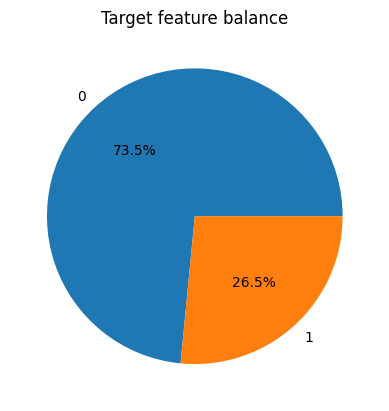

In [10]:
# checking the target feature balance
plt.pie(
    df["target"].value_counts(),
    labels=df["target"].value_counts().index,
    autopct="%.1f%%",
)
plt.title("Target feature balance")
plt.show()

An unbalanced distribution of the target feature was revealed - about a quarter of customers refused the company's services.

In [11]:
# for convenience, we divide the dataset into existing and former customers, and the features into categorical and quantitative
dfs = {"all": df, "current": df[df["target"] == 0], "lost": df[df["target"] == 1]}
cat_features = df.select_dtypes(include="object").columns.tolist()
num_features = df.select_dtypes(exclude="object").columns.tolist()

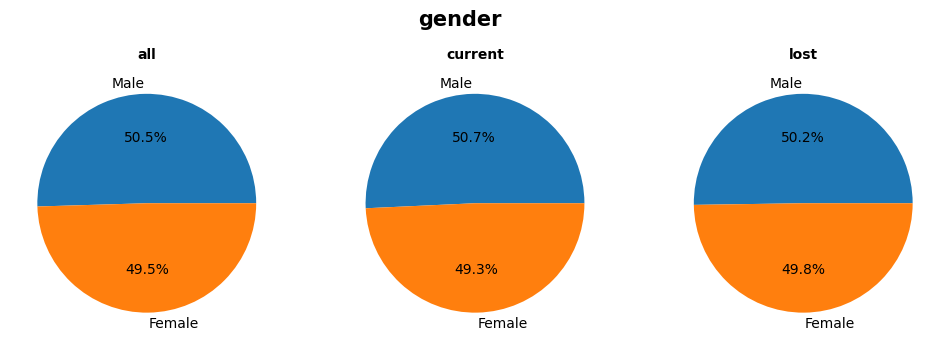

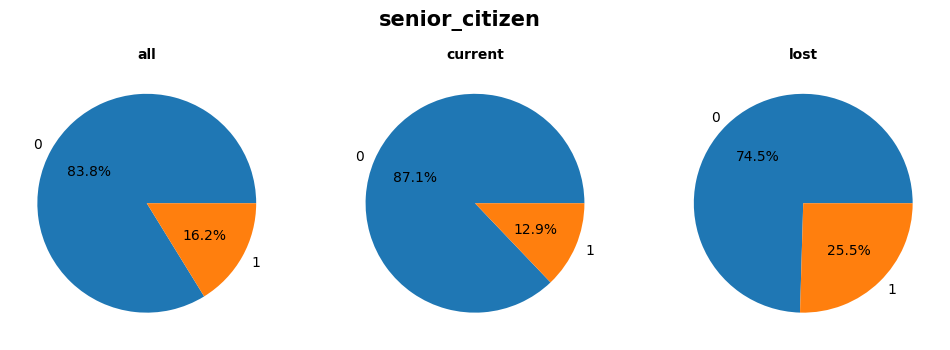

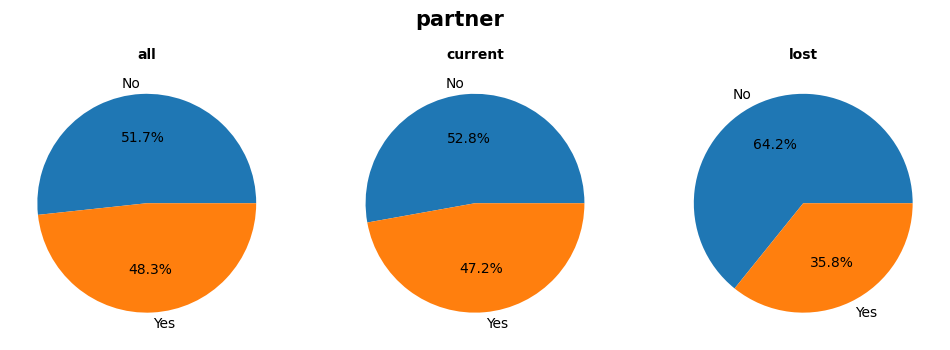

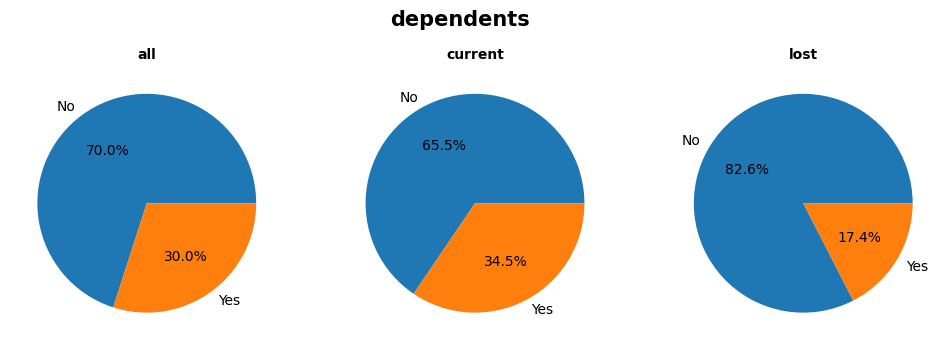

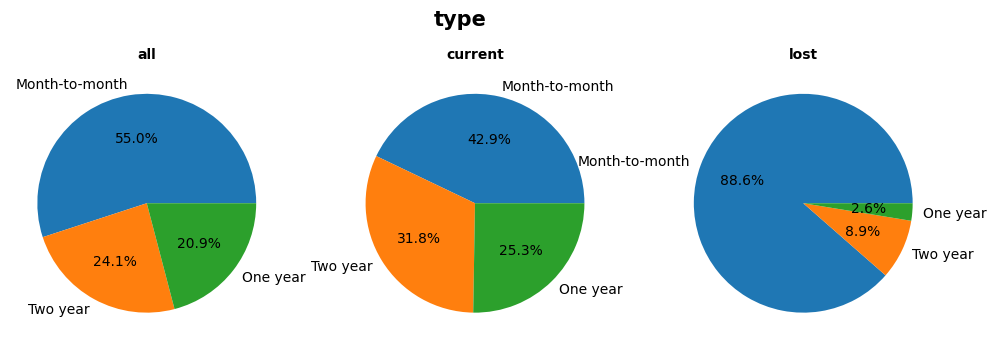

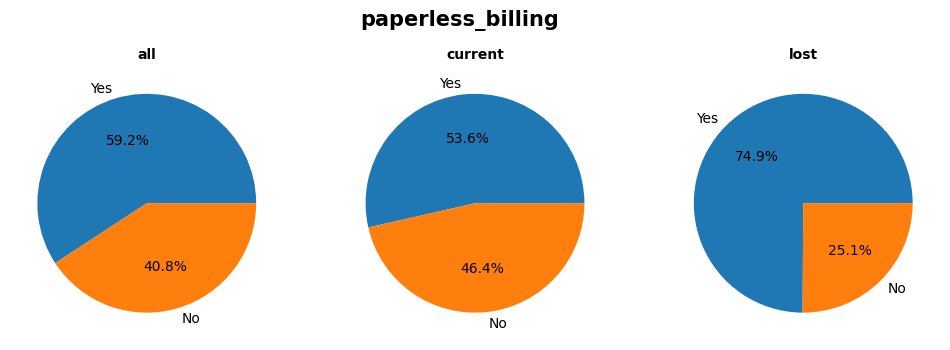

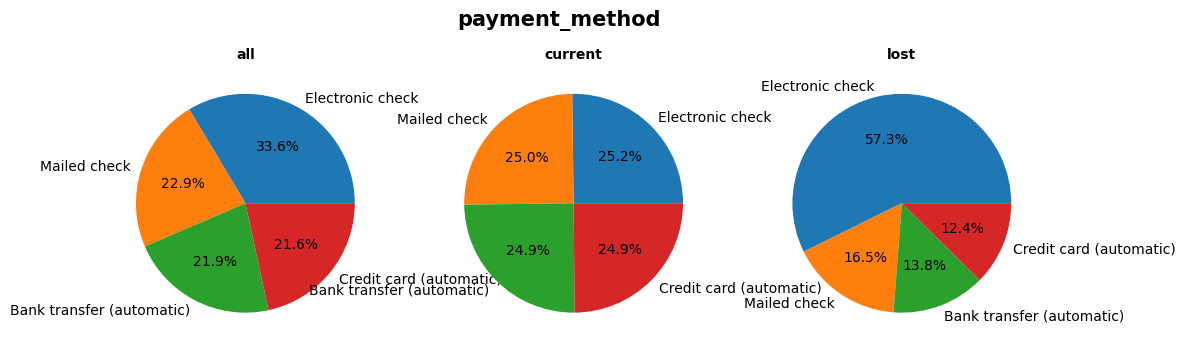

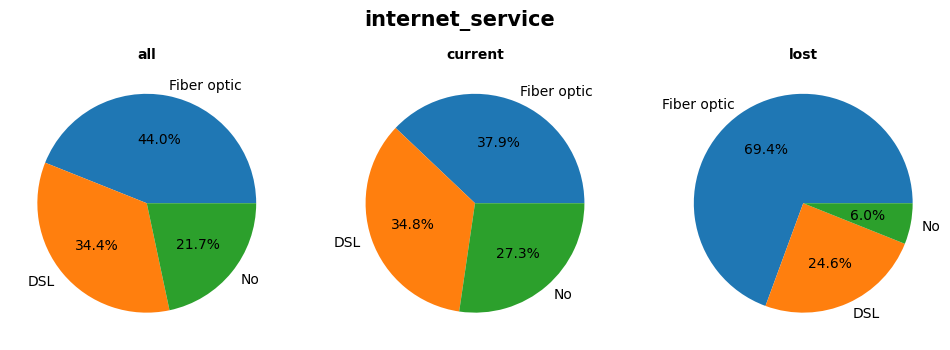

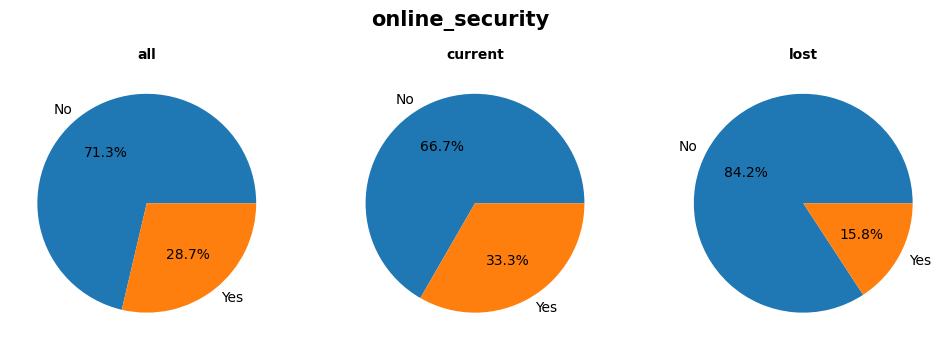

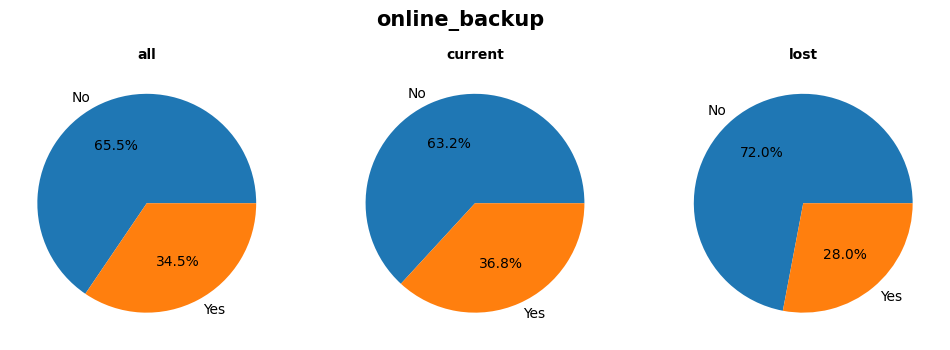

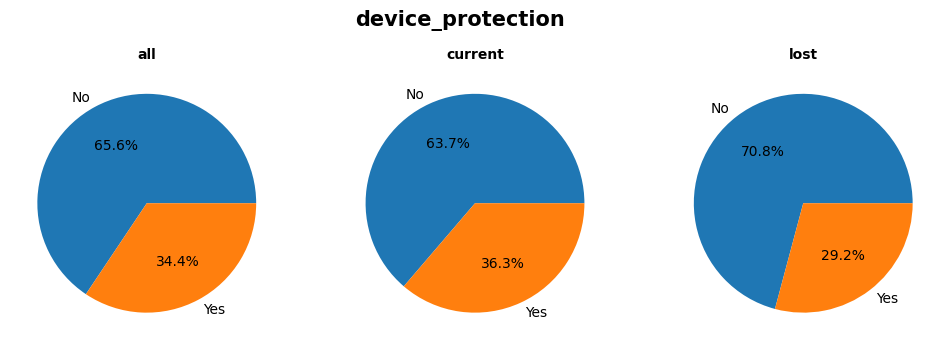

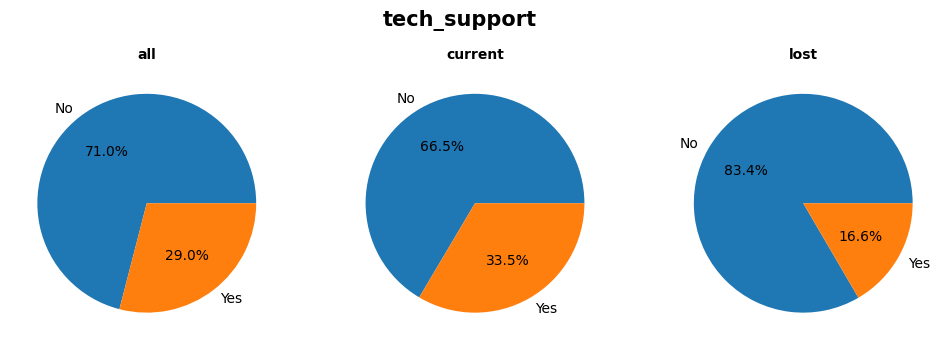

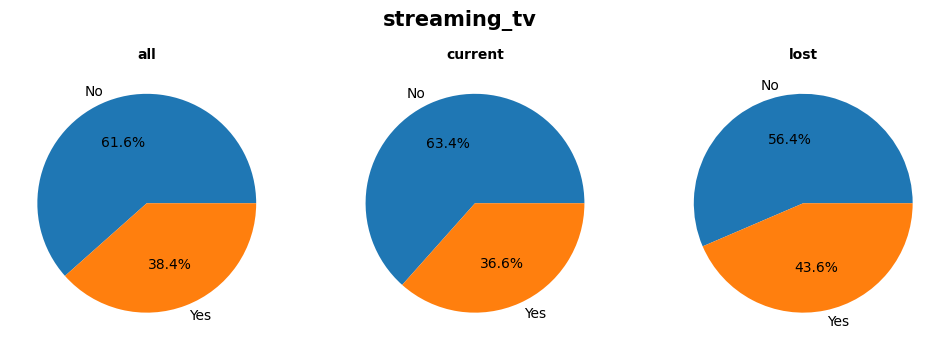

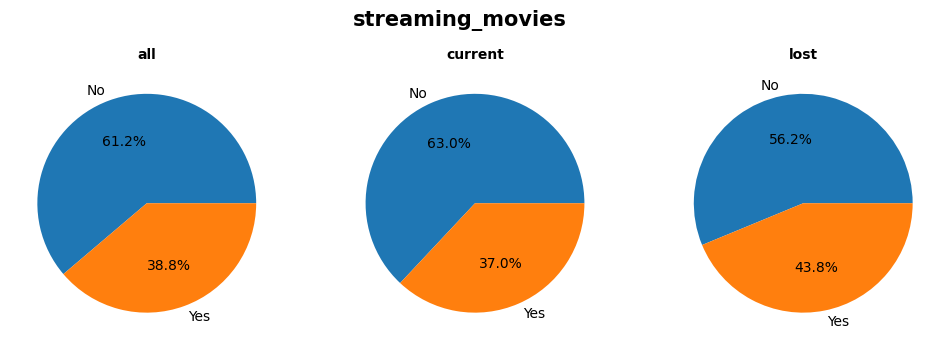

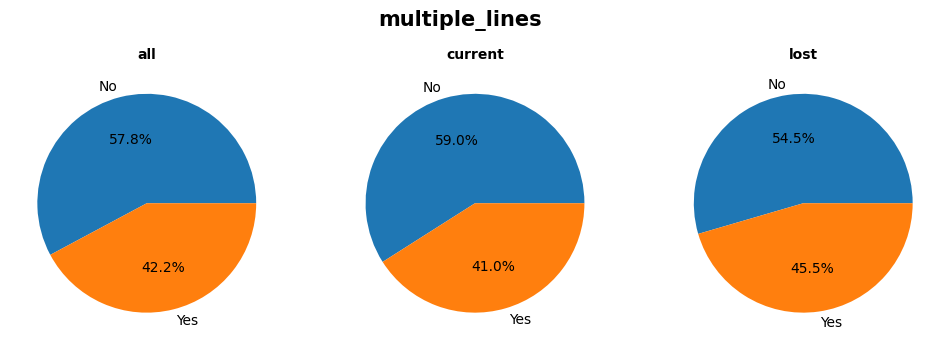

In [12]:
# comparison of categorical features
for col in cat_features:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for data, ax in zip(dfs.keys(), axes):
        ax.pie(
            dfs[data][col].value_counts(),
            labels=df[col].value_counts().index,
            autopct="%.1f%%",
        )
        ax.set_title(data, size=10, fontweight="bold")
        fig.suptitle(col, size=15, fontweight="bold")
    plt.show()

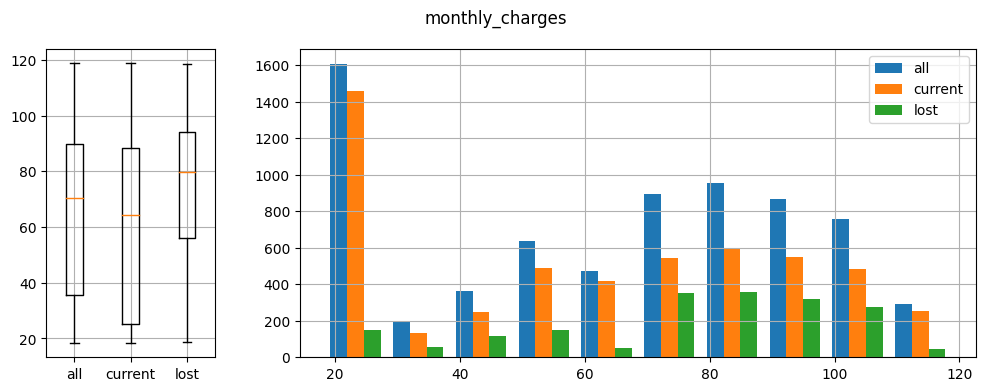

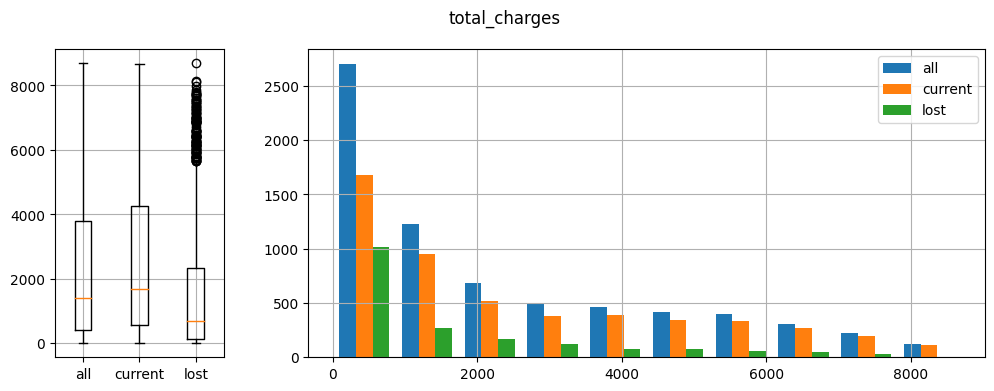

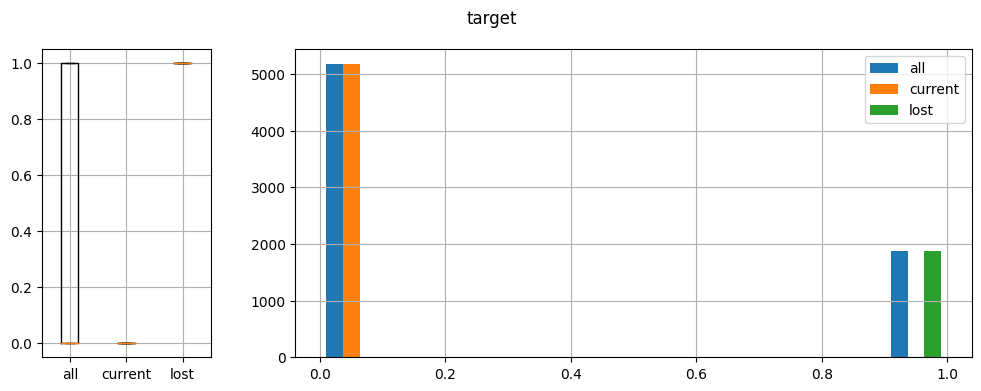

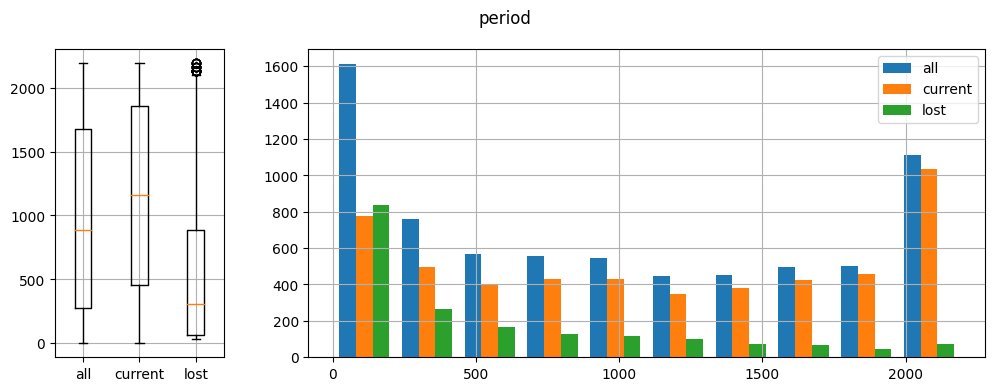

In [13]:
# comparison of quantitative features
for col in num_features:
    fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 4]}, figsize=(12, 4))
    axs[0].boxplot(
        (dfs["all"][col], dfs["current"][col], dfs["lost"][col]),
        labels=["all", "current", "lost"],
    )
    axs[0].grid()
    axs[1].hist(
        (dfs["all"][col], dfs["current"][col], dfs["lost"][col]),
        label=["all", "current", "lost"],
    )
    plt.legend()
    plt.grid()
    plt.suptitle(col)
    plt.show()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'period']
interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'period']
interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'period']


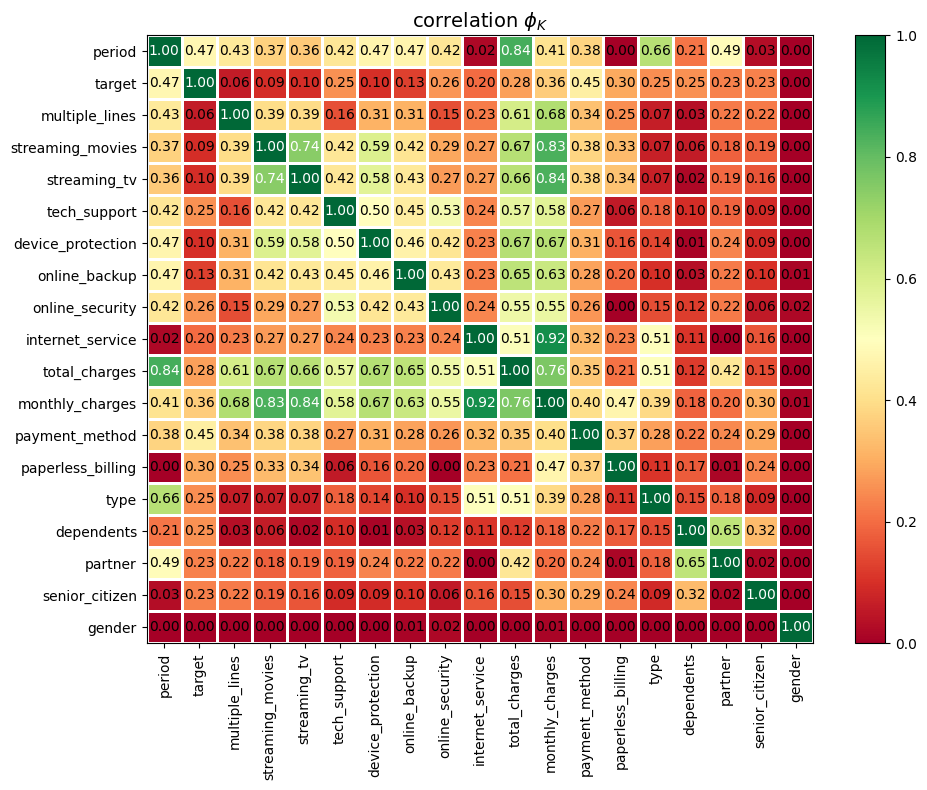

In [14]:
# checking for correlations
plot_correlation_matrix(
    df.phik_matrix().values,
    x_labels=df.phik_matrix().columns,
    y_labels=df.phik_matrix().index,
    vmin=0,
    vmax=1,
    title=r"correlation $\phi_K$",
    figsize=(10, 8),
)
plt.tight_layout()

The statistics comparison of existing and departed customers suggests some conclusions. For example:
- the gender of the client does not correlate with any other feature, this feature can be omitted in the model;
- another feature that will not be used in the model is the total amount of payments, as it directly depends on the period of use and the monthly cost;
- pensioners refuse services more often than others;
- customers who pay for the operator's services for 1 or 2 years at once are more loyal;
- most of the customers use a cheap package of services;
- on average, the former client brought the operator more profit per month than the remaining one (presumably, they used a more expensive package of services), but for various reasons (inconvenience of use, uselessness of services, more profitable alternatives, etc.), their period of using the services provided is not long, for more than half of these clients it does not even reach a year, so the total income from them is small;
- the operator has gained a large number of loyal customers, but it also has many new users;
- considering that the probability of customer churn is higher at the very beginning of using the services, it is worth working out attractive offers with new customers in order to retain them.

In [15]:
# deleting features
cat_features = cat_features[1:]
num_features = num_features[::3]

## Selection of models
For forecasting of customer churn, it is necessary to choose the most appropriate model. In this project, we will use the most common models, and their quality will be assessed by the ROC-AUC metric on cross-validation of the training set.

### Data preparation
Preparing data for training the model consists of the following operations:
- separation of the target feature;
- splitting the dataset into training and test samples while maintaining the balance of classes of the target feature;
- coding and scaling of features.

(5282, 16) (1761, 16) (5282,) (1761,)


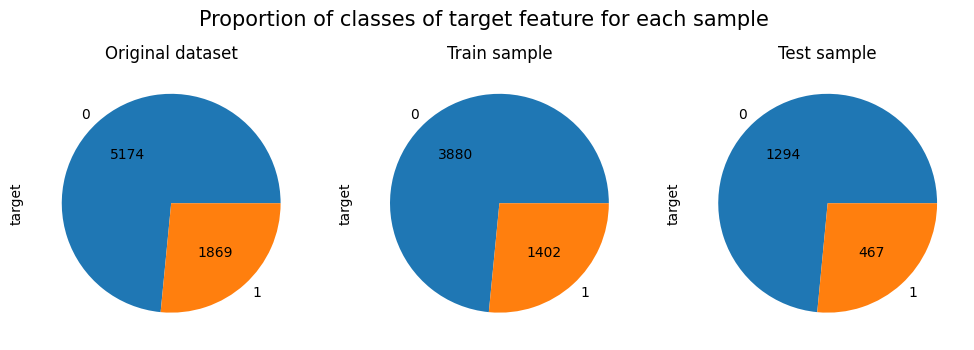

In [16]:
# separation of the target feature
X, y = df.drop(["gender", "total_charges", "target"], axis=1), df["target"]

# splitting the dataset into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)


# check for quantity and proportion
def draw_pie(data, name, axes):
    data.value_counts().plot(
        kind="pie",
        title=name,
        labels=data.value_counts().index,
        autopct=lambda p: "{:.0f}".format(p * data.count() / 100),
        ax=axes,
    )


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Proportion of classes of target feature for each sample", fontsize=15)
draw_pie(y, "Original dataset", axes[0])
draw_pie(y_train, "Train sample", axes[1])
draw_pie(y_test, "Test sample", axes[2])

In [17]:
# scaling
scaler = RobustScaler().fit(X_train[num_features])
X_train_scaled, X_test_scaled = (
    X_train.copy().drop(cat_features, axis=1),
    X_test.copy().drop(cat_features, axis=1),
)
X_train_scaled[num_features] = scaler.transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

# coding
encoder = OneHotEncoder(drop="first").fit(X_train[cat_features])
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[cat_features]).toarray(),
    columns=encoder.get_feature_names_out(),
    index=X_train.index,
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[cat_features]).toarray(),
    columns=encoder.get_feature_names_out(),
    index=X_test.index,
)
# saving features for LogisticRegression and RandomForest
X_train_coded = pd.concat([X_train_encoded, X_train_scaled], axis=1)
X_test_coded = pd.concat([X_test_encoded, X_test_scaled], axis=1)
# saving features for LightGBM
X_train_lg, X_test_lg = X_train.copy(), X_test.copy()
X_train_lg[cat_features], X_test_lg[cat_features] = (
    X_train_lg[cat_features].astype("category"),
    X_test_lg[cat_features].astype("category"),
)

### Selection of models
Among the models, let's see how LogisticReggression, RandomForest, CatBoost and LightGBM will show themselves. The optimal hyperparameters for the models will be selected using optuna. The best result of each model will be saved in a comparative table.


In [18]:
# models
models = [
    "LogisticRegression",
    "RandomForest",
    "CatBoost",
    "LightGBM",
]
# creating comparative table
results = pd.DataFrame(
    {
        "model_name": [],
        "params": [],
        "roc_auc_score_cv": [],
        "roc_auc_score_train": [],
        "learning_duration": [],
    }
)


# function for saving the models' results into the comparative table
def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])


def write_results(model_name):
    global results
    if model_name == "LogisticRegression":
        study = study_lr
        X = X_train_coded
    elif model_name == "RandomForest":
        study = study_rf
        X = X_train_coded
    elif model_name == "CatBoost":
        study = study_cb
        X = X_train
    elif model_name == "LightGBM":
        study = study_lg
        X = X_train_lg

    model = study.user_attrs["best_model"]
    learning_start = time.time()
    model.fit(X, y_train)
    roc_auc_score_train = roc_auc_score(y_train, model.predict_proba(X)[:, 1])
    learning_end = time.time()
    learning_duration = learning_end - learning_start

    results.loc[len(results), results.columns] = (
        model_name,
        model,
        study.best_value,
        roc_auc_score_train,
        learning_duration,
    )
    display(results)

#### Logistic Reggression

In [19]:
# Logistic Regression
def optimize_lr(trial):
    model = LogisticRegression(
        C=trial.suggest_float("C", 1e-10, 1e10, log=True),
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    score = (
        cross_val_score(
            model,
            X_train_coded,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=N_JOBS,
        )
    ).mean()
    trial.set_user_attr(key="best_model", value=model)
    return score


study_lr = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study_lr.optimize(optimize_lr, n_trials=50, callbacks=[callback])
write_results(models[0])

[I 2023-03-09 13:46:49,843] A new study created in memory with name: no-name-dccc7559-2615-468d-b02c-42afc4d0641e
[I 2023-03-09 13:46:50,906] Trial 0 finished with value: 0.8409447886963516 and parameters: {'C': 0.03691370646090206}. Best is trial 0 with value: 0.8409447886963516.
[I 2023-03-09 13:46:50,966] Trial 1 finished with value: 0.8349906581957196 and parameters: {'C': 0.0014327584117606639}. Best is trial 0 with value: 0.8409447886963516.
[I 2023-03-09 13:46:50,999] Trial 2 finished with value: 0.8285362352332906 and parameters: {'C': 1.9695407096775962e-08}. Best is trial 0 with value: 0.8409447886963516.
[I 2023-03-09 13:46:51,051] Trial 3 finished with value: 0.842673629607579 and parameters: {'C': 593816355.4803588}. Best is trial 3 with value: 0.842673629607579.
[I 2023-03-09 13:46:51,105] Trial 4 finished with value: 0.8426828082077314 and parameters: {'C': 48.03524169259649}. Best is trial 4 with value: 0.8426828082077314.
[I 2023-03-09 13:46:51,143] Trial 5 finished wi

,model_name,params,roc_auc_score_cv,roc_auc_score_train,learning_duration
0,LogisticRegression,"LogisticRegression(C=15.153840660695684, class...",0.842712,0.846489,0.016593


#### Random Forest

In [20]:
# Random Forest
def optimize_rf(trial):
    model = RandomForestClassifier(
        max_depth=trial.suggest_int("max_depth", 2, 32, log=True),
        n_estimators=trial.suggest_int("n_estimators", 10, 1000),
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    score = (
        cross_val_score(
            model,
            X_train_coded,
            y_train,
            cv=cv,
            scoring="roc_auc",
            n_jobs=N_JOBS,
        )
    ).mean()
    trial.set_user_attr(key="best_model", value=model)
    return score


study_rf = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study_rf.optimize(optimize_rf, n_trials=50, callbacks=[callback])
write_results(models[1])

[I 2023-03-09 13:47:00,688] A new study created in memory with name: no-name-ae89e2f2-0020-42ac-af68-eb006e730c91
[I 2023-03-09 13:47:02,471] Trial 0 finished with value: 0.8530405712405603 and parameters: {'max_depth': 6, 'n_estimators': 364}. Best is trial 0 with value: 0.8530405712405603.
[I 2023-03-09 13:47:05,414] Trial 1 finished with value: 0.8394708073512362 and parameters: {'max_depth': 2, 'n_estimators': 940}. Best is trial 0 with value: 0.8530405712405603.
[I 2023-03-09 13:47:06,927] Trial 2 finished with value: 0.8543080471385747 and parameters: {'max_depth': 9, 'n_estimators': 268}. Best is trial 2 with value: 0.8543080471385747.
[I 2023-03-09 13:47:08,055] Trial 3 finished with value: 0.8402775449398886 and parameters: {'max_depth': 2, 'n_estimators': 347}. Best is trial 2 with value: 0.8543080471385747.
[I 2023-03-09 13:47:14,499] Trial 4 finished with value: 0.8401805886315922 and parameters: {'max_depth': 21, 'n_estimators': 863}. Best is trial 2 with value: 0.85430804

,model_name,params,roc_auc_score_cv,roc_auc_score_train,learning_duration
0,LogisticRegression,"LogisticRegression(C=15.153840660695684, class...",0.842712,0.846489,0.016593
1,RandomForest,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.855448,0.908299,1.297462


#### Cat Boost

In [21]:
# CatBoost
def optimize_cb(trial):
    model = CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        cat_features=[X_train.columns.get_loc(col) for col in cat_features],
        verbose=False,
        auto_class_weights="Balanced",
        random_state=RANDOM_STATE,
    )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    score = (
        cross_val_score(
            model, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=N_JOBS
        )
    ).mean()
    trial.set_user_attr(key="best_model", value=model)
    return score


study_cb = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study_cb.optimize(optimize_cb, n_trials=50, callbacks=[callback])
write_results(models[2])

[I 2023-03-09 13:49:46,432] A new study created in memory with name: no-name-10499346-c8a0-4a51-b9a5-f2a45936290b
[I 2023-03-09 13:49:52,357] Trial 0 finished with value: 0.8548718129497906 and parameters: {'iterations': 485, 'learning_rate': 0.0051953797428910585, 'depth': 4, 'l2_leaf_reg': 24.368347409710843, 'bootstrap_type': 'Bayesian', 'random_strength': 0.0018059344850299287, 'bagging_temperature': 2.6053713271903343, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 0 with value: 0.8548718129497906.
/Users/asyl/Desktop/DS/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2023-03-09 13:50:43,432] Trial 1 finished with value: 0.82287392024149 and parameters: {'iterations': 875, 'learning_rate': 0.012554383508980613, 'depth': 10, 'l2_leaf_reg': 0.0003412412018106683, 'bootstrap_type': 'Bayes

,model_name,params,roc_auc_score_cv,roc_auc_score_train,learning_duration
0,LogisticRegression,"LogisticRegression(C=15.153840660695684, class...",0.842712,0.846489,0.016593
1,RandomForest,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.855448,0.908299,1.297462
2,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,0.923688,0.982796,2.896023


#### LightGBM

In [22]:
# LightGBM
def optimize_lg(trial):
    model = LGBMClassifier(
        num_leaves=trial.suggest_int("num_leaves", 2, 512),
        min_child_samples=trial.suggest_int("min_child_samples", 1, 100),
        objective="binary",
        boosting_type="gbdt",
        verbosity=-1,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    score = (
        cross_val_score(
            model, X_train_lg, y_train, cv=cv, scoring="roc_auc", n_jobs=N_JOBS
        )
    ).mean()
    trial.set_user_attr(key="best_model", value=model)
    return score


study_lg = optuna.create_study(
    direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
)
study_lg.optimize(optimize_lg, n_trials=50, callbacks=[callback])
write_results(models[3])

[I 2023-03-09 13:59:04,722] A new study created in memory with name: no-name-b8876075-ddff-4a9b-8b1e-e946f8e9faf4
[I 2023-03-09 13:59:05,230] Trial 0 finished with value: 0.8863656007478665 and parameters: {'num_leaves': 220, 'min_child_samples': 36}. Best is trial 0 with value: 0.8863656007478665.
[I 2023-03-09 13:59:05,434] Trial 1 finished with value: 0.8905289315221593 and parameters: {'num_leaves': 60, 'min_child_samples': 94}. Best is trial 1 with value: 0.8905289315221593.
[I 2023-03-09 13:59:05,912] Trial 2 finished with value: 0.8862933339600373 and parameters: {'num_leaves': 300, 'min_child_samples': 27}. Best is trial 1 with value: 0.8905289315221593.
[I 2023-03-09 13:59:05,997] Trial 3 finished with value: 0.8546916682334263 and parameters: {'num_leaves': 2, 'min_child_samples': 35}. Best is trial 1 with value: 0.8905289315221593.
[I 2023-03-09 13:59:06,238] Trial 4 finished with value: 0.8891282875839522 and parameters: {'num_leaves': 443, 'min_child_samples': 87}. Best is

,model_name,params,roc_auc_score_cv,roc_auc_score_train,learning_duration
0,LogisticRegression,"LogisticRegression(C=15.153840660695684, class...",0.842712,0.846489,0.016593
1,RandomForest,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.855448,0.908299,1.297462
2,CatBoost,<catboost.core.CatBoostClassifier object at 0x...,0.923688,0.982796,2.896023
3,LightGBM,"LGBMClassifier(class_weight='balanced', min_ch...",0.895356,0.980496,0.496177


## Model testing
CatBoostClassifier turned out to be the best model in cross-validation, while LightGBM was faster, but showed a slightly worse result. Let's check the best model on the test set. The models and their optimal hyperparameters are stored in the `results` table.

In [23]:
# final commparative table
results = results.set_index("model_name")
results

,params,roc_auc_score_cv,roc_auc_score_train,learning_duration
model_name,,,,
LogisticRegression,"LogisticRegression(C=15.153840660695684, class...",0.842712,0.846489,0.016593
RandomForest,"(DecisionTreeClassifier(max_depth=8, max_featu...",0.855448,0.908299,1.297462
CatBoost,<catboost.core.CatBoostClassifier object at 0x...,0.923688,0.982796,2.896023
LightGBM,"LGBMClassifier(class_weight='balanced', min_ch...",0.895356,0.980496,0.496177


In [24]:
# function for showing model stats
def test_model(model_name):
    if model_name == "LogisticRegression" or model_name == "RandomForest":
        features_train = X_train_coded
        features_test = X_test_coded
    elif model_name == "CatBoost":
        features_train = X_train
        features_test = X_test
    elif model_name == "LightGBM":
        features_train = X_train_lg
        features_test = X_test_lg

    model = results.loc[model_name, "params"]
    model.fit(features_train, y_train)
    pred = model.predict(features_test)
    proba = model.predict_proba(features_test)[:, 1]
    score = roc_auc_score(y_test, proba)

    print(model)
    if model_name == "CatBoost":
        print("Hyperparameters:", model.get_params())
    print(classification_report(y_test, pred))
    print("ROC-AUC score:", round(score, 4))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(model_name)

    cm = confusion_matrix(y_test, pred)
    group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [
        f"{v1}\n{v2}\n{v3}"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt="", cmap="Blues", ax=axs[0])
    axs[0].set_title("Confusion matrix")

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], "--", color="r", label="random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC-curve of the model")
    plt.show()

Hyperparameters: {'iterations': 824, 'learning_rate': 0.07013599638608807, 'depth': 4, 'l2_leaf_reg': 0.0002452965181665276, 'od_wait': 16, 'od_type': 'IncToDec', 'verbose': False, 'auto_class_weights': 'Balanced', 'random_strength': 0.01751075289951375, 'bagging_temperature': 0.031010564008441016, 'bootstrap_type': 'Bayesian', 'random_state': 270223, 'cat_features': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]}
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1294
           1       0.71      0.83      0.77       467

    accuracy                           0.87      1761
   macro avg       0.82      0.86      0.84      1761
weighted avg       0.88      0.87      0.87      1761

ROC-AUC score: 0.9297


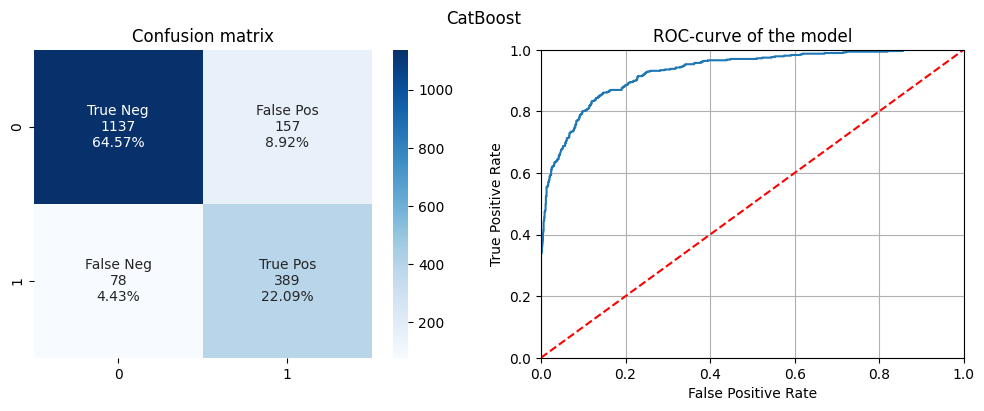

In [25]:
test_model(models[2])

The accuracy of the positively predicted responses of the CatBoost model with given hyperparameters was 0.71, i.e. of all the customers that the model suggested could potentially terminate the services of an operator, only 71% actually did so. Recall was 0.83 - the model missed 17% of the departed users.

The ROC-AUC metric reached 0.93, which is a good result. The model is quite effective in identifying users who are prone to leaving, while making few false positive predictions, which saves company resources on retaining customers who are not going to leave.

,importance
period,55.897219
monthly_charges,21.861158
type,7.235199
payment_method,4.447376
internet_service,2.924691
streaming_movies,1.359512
paperless_billing,1.145676
senior_citizen,1.013330
dependents,0.760761
streaming_tv,0.702790


<AxesSubplot: title={'center': 'Feature importances'}>

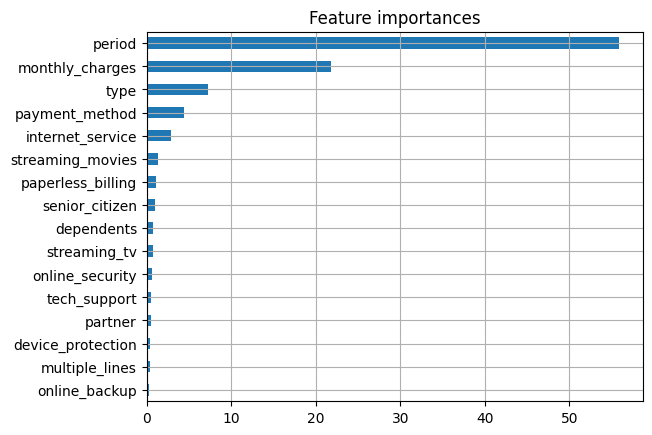

In [26]:
# feature importances
feature_importance = pd.DataFrame(
    results.loc["CatBoost", "params"].get_feature_importance(),
    index=X_test.columns,
    columns=["importance"],
).sort_values("importance", ascending=False)
display(feature_importance)

feature_importance.sort_values("importance").plot.barh(
    grid=True, legend=False, title="Feature importances"
)

For the model, the 'lifetime' of the client has become a fundamental feature. Another important feature is the cost of services per month, less important - the type (monthly, annual) and method of payment, as well as the type of Internet connection or its availability. The importance of the rest of the features is not significant.

## Conclusion
The ultimate goal of the project has been successfully achieved - a model for predicting customer churn has been developed. The work on the project implementation consisted of several stages.

**1. Initial data processing.** The company provided 4 separate datasets that contained various information about the client's personal data, the terms of the contract and the tariffs used. First of all, the concept of each of the dataset columns was reached, some of them were clarified at a meeting with the team leader. Also, the team leader set the quality metric (ROC-AUC) and its minimum indicator for project delivery.

To create a forecasting model, all the features of the objects first must be combined into a single database, which was done thanks to the existing key - the user ID. After the merger, the problem of a small amount of data (7043 objects in total) became apparent, which required careful treatment of all records.

The absence of an end date for the contract was a key factor in determining the target attribute whether the client left or not. Another auxiliary feature was also created, which later turned out to be the most important feature for the model. This is the 'lifetime' of the client, how many days have passed from the day the contract began to an end, or until the day the data was exported (February 1, 2020) if the user was an active client of the company at that moment. With the creation of new signs, the need for the start and end dates of the contract was no longer necessary, and they were removed.
A detailed study of the missing values in the columns of total amount of payments showed that the client had only concluded an agreement and, accordingly, had not yet made a single payment.
Fortunately, the remaining missing values in the dataset were related to categorical features (connected services) and meant that the client did not use these services. Thus, all missing values were filled with the corresponding values, and the original quantity of objects was retained.

Abnormal values were not revealed, excessively high values of the cost are explained by the long period of use and expensive services.

After the initial data processing, the client ID was converted into a table index so as not to interfere with the model process.
    
**2. Data analysis.** In the course of data analysis, an imbalance in the classes of the target feature was revealed, there are 3 existing clients per 1 departed one. Due to the small amount of data, the issue of imbalance will be solved by the built-in functions of the models.

Then, a 'face-to-face' comparison of the statistics of current and departed customers was made. Such a comparison made it possible to clearly show the importance of the initial period of using the operator's services. So, if the client uses the services for a year or more, then the probability of his leaving is significantly reduced. Companies should pay special attention when working with new customers.

The need for a predictive model is heightened by the fact that the lost client, on average, brought in more profit than the active client through the use of more expensive services. The company is losing a lot of revenue by allowing 'wealthy' customers to leave.

It is worth noting that the company has quite a lot of loyal users, but a significant part of customers use a cheap package of services.

In addition, other regularities are also visible. For example, customers who subscribe to services for 1 or 2 years at once are more loyal. On the other hand, retirees are more likely than others to refuse the services of a company. It also turned out that the gender of the client does not affect other characteristics of the use of services. Along with gender, it was decided to remove the total amount of payments, since it is directly formed from the monthly cost and duration of use of services.

**3. Selection of models.** Some of the most popular models were selected to solve the binary classification prediction problem: linear model (Logistic Regression), Random Forest and more advanced Cat Boost and Light GBM. Before starting training, 25% of the data from the total dataset, while maintaining the overall balance (in this case, the imbalance) of the classes of the target feature, was set aside for the final check of the best model. The preparation of features for different models was carried out in different ways. So, for Logistic Regression and Random Forest models, categorical features were encoded by the OneHot encoder, since there are few categories in them, and quantitative features are scaled using Robust Scale. For the Light GBM model, it was enough to transform the categorical features into the `category` format, otherwise, it and the Cat Boost model process the features with their internal functions.

Hyperparameter fit for the 4 models was cross-validated on the training set with help of optuna, and their best scores are stored in a comparison table along with the ROC-AUC metric and training time. As a result, the Cat Boost model worked best with the following hyperparameters:

{'iterations': 824, 'learning_rate': 0.07013599638608807, 'depth': 4, 'l2_leaf_reg': 0.0002452965181665276, 'od_wait': 16, 'od_type': 'IncToDec', 'verbose': False, 'auto_class_weights': 'Balanced', 'random_strength': 0.01751075289951375, 'bagging_temperature': 0.031010564008441016, 'bootstrap_type': 'Bayesian', 'random_state': 270223, 'cat_features': [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14]}

**4. Testing the model.** The accuracy of the positively predicted responses of the final model was 0.71, i.e. of all the customers that the model suggested could potentially disconnect the operator's services, 71% actually did so. Recall was 0.83 - the model missed 17% of lost users (only 4.4% of all customers).

The target ROC-AUC metric reached 0.93. The model is quite effective in identifying users who are inclined to leave, while making few false positive predictions (only 8.9%), which saves company resources on retaining customers who are not going to leave.

The main sign for determining whether the client will leave or not is his duration of use of services. In second place is the monthly cost of the services provided. As noted in the data analysis, new customers with an expensive package of services, which the company should focus on, are highly likely to leave.